## This notebook creates a slice consists of multiple nodes connected with bridge network and attached storage. It also generate a inventory file ready to be used by kubespray for kubernetes installation

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [2]:
bastion_public_addr = 'bastion-1.fabric-testbed.net'
bastion_private_ipv4_addr = '192.168.11.226'
bastion_private_ipv6_addr = '2600:2701:5000:a902::c'

bastion_username = 'fengping_0051367226'

bastion_key_filename = os.environ['HOME'] + "/.ssh/id_rsa_fabric"

ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()
    

In [3]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"FABRIC Orchestrator         : {orchestrator_host}")

FABRIC Credential Manager   : cm.fabric-testbed.net
FABRIC Orchestrator         : orchestrator.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [4]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [5]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: NCSA: { cpu: 6/6 , core: 184/192 , ram: 1,496/1,536 G, disk: 60,400/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 8,640/9,600 G, unit: 9/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 379/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 318/320 , ram: 2,552/2,560 G, disk: 116,390/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 3/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { 

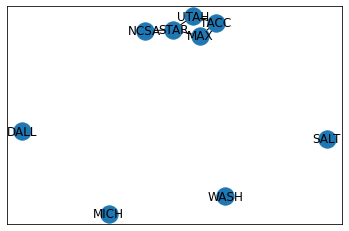

In [6]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice
In Release 1.0, user is expected to assign the IP addresses manually. Please use the example comands indicated below:

## Configure Slice Parameters



In [7]:
from fabrictestbed.slice_editor import ComponentModelType

slice_name = 'KubernetesSlice1'
site = 'NCSA'
node1_name = 'Node1'
node2_name = 'Node2'
network_service_name='bridge1'
nic1_name = 'node1-nic1'
nic2_name = 'node2-nic1'
username = 'centos'
image = 'default_centos_8'
image_type = 'qcow2'
cores = 4
ram = 20
disk = 100

nvme_name='nvme1'
nvme_model_type = ComponentModelType.NVME_P4510

In [8]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name=node1_name, site=site)

# Set capacities
cap = Capacities()
cap.set_fields(core=cores, ram=ram, disk=disk)

# Set Properties
n1.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Add node
n2 = t.add_node(name=node2_name, site=site)

# Set properties
n2.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Shared Cards
n1.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=nic1_name)
n2.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=nic2_name)

# Add the PCI NVMe device
n2.add_component(model_type=nvme_model_type, name=nvme_name)

# L2Bridge Service
t.add_network_service(name=network_service_name, nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                            slice_graph=slice_graph, 
                                            ssh_key=ssh_key_pub)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: 0014ffea-942b-4950-b828-a73cacb7c71e


## Get the Slice

In [9]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    


return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
    slice = wait_for_slice(slice, progress=True)

print()
print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice ................... Timeout exceeded (180 sec). Slice: KubernetesSlice1 (Configuring)

Slice Name : KubernetesSlice1
ID         : 0014ffea-942b-4950-b828-a73cacb7c71e
State      : Configuring
Lease End  : 2021-11-18 19:46:15


## Get the Nodes

Retrieve the node information and save the management IP address.


### Get the Topology

In [12]:
nodes=[]

In [13]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

### Configure Node1

Use ssh to configure eth1 on  node 1.  

```
ip addr add 192.168.10.51/24 dev eth1
```

In [14]:
node1 = experiment_topology.nodes[node1_name]

management_ip_node1 = str(node1.get_property(pname='management_ip'))
print("Node Name        : {}".format(node1.name))
print("Management IP    : {}".format(management_ip_node1))
print()
nodes.append({"name":"node1","pubip": management_ip_node1, "privip": "192.168.10.51"})

Node Name        : Node1
Management IP    : 141.142.140.51



In [15]:
from ipaddress import ip_address, IPv4Address
def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

import paramiko
management_ip = management_ip_node1

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

bastion=paramiko.SSHClient()
bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename,passphrase="790325")


bastion_transport = bastion.get_transport()
if validIPAddress(management_ip) == 'IPv4':
    src_addr = (bastion_private_ipv4_addr, 22)
elif validIPAddress(management_ip) == 'IPv6':
    src_addr = (bastion_private_ipv6_addr, 22)
else:
    print('Management IP Invalid: {}'.format(management_ip))

dest_addr = (management_ip, 22)
bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

client.connect(management_ip,username=username,pkey = key, sock=bastion_channel)
stdin, stdout, stderr = client.exec_command('sudo systemctl disable NetworkManager')
stdin, stdout, stderr = client.exec_command('sudo systemctl stop NetworkManager')
stdin, stdout, stderr = client.exec_command('sudo ip addr add 192.168.10.51/24 dev eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

stdin, stdout, stderr = client.exec_command('ifconfig eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

client.close()


eth1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 192.168.10.51  netmask 255.255.255.0  broadcast 0.0.0.0
        ether 0a:12:62:fd:b9:81  txqueuelen 1000  (Ethernet)
        RX packets 16  bytes 5792 (5.6 KiB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 61  bytes 10578 (10.3 KiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0




### Configure Node2

Use ssh to configure eth1 on each Node 2.  

```
ip addr add 192.168.10.52/24 dev eth1
```

In [16]:
node2 = experiment_topology.nodes[node2_name]

management_ip_node2 = str(node2.get_property(pname='management_ip'))
print("Node Name        : {}".format(node2.name))
print("Management IP    : {}".format(management_ip_node2))
print()
nodes.append({"name":"node2","pubip": management_ip_node2, "privip": "192.168.10.52"})

Node Name        : Node2
Management IP    : 141.142.140.61



In [17]:
from ipaddress import ip_address, IPv4Address
def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

import paramiko
management_ip = management_ip_node2

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

bastion=paramiko.SSHClient()
bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename,passphrase="790325")


bastion_transport = bastion.get_transport()
if validIPAddress(management_ip) == 'IPv4':
    src_addr = (bastion_private_ipv4_addr, 22)
elif validIPAddress(management_ip) == 'IPv6':
    src_addr = (bastion_private_ipv6_addr, 22)
else:
    print('Management IP Invalid: {}'.format(management_ip))

dest_addr = (management_ip, 22)
bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

client.connect(management_ip,username=username,pkey = key, sock=bastion_channel)
stdin, stdout, stderr = client.exec_command('sudo systemctl disable NetworkManager')
stdin, stdout, stderr = client.exec_command('sudo systemctl stop NetworkManager')
stdin, stdout, stderr = client.exec_command('sudo ip addr add 192.168.10.52/24 dev eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

stdin, stdout, stderr = client.exec_command('ifconfig eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

client.close()


eth1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 192.168.10.52  netmask 255.255.255.0  broadcast 0.0.0.0
        ether 0a:a6:98:56:67:38  txqueuelen 1000  (Ethernet)
        RX packets 15  bytes 5430 (5.3 KiB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 61  bytes 10578 (10.3 KiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0




## Generate kubespray inventory file

In [18]:
%cd /home/fabric/work


/home/fabric/work


In [19]:
import yaml
from jinja2 import Environment, FileSystemLoader
#hosts=[{"name": "node1", "pubip": "192.168.0.1"}, {"name":"node2"},{"name":"node3"}]
#if __name__ == "__main__":
#values = yaml.load(open('./value.yaml'))
# Load templates file from templtes folder
env = Environment(loader = FileSystemLoader('./templates'),   trim_blocks=True, lstrip_blocks=True)
template = env.get_template('hosts.j2')
#for service in values["services"]:
file=open("hosts.yaml", "w")
file.write(template.render(hosts=nodes, 
                           bastion_public_addr=bastion_public_addr, 
                           bastion_username=bastion_username,
                           bastion_key_filename=bastion_key_filename,
                           ssh_key_file_priv=ssh_key_file_priv))
file.close()

## Delete Slice

In [30]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
